#### Detection of Bot/Malware Generated Network Traffic 

Malware traffic is often hard to detect as it uses real users' PC or browsers in order to generate fraudulent activity and Spam. The purpose of this project is to build a simple supervised model that will be trained to detect malware based traffic in a network traffic log or capture. When the model flags an IP as generating malware based spam and fraudulent activity  it can be listed for quarantine or further analysis. 


The Dataset used here is part of a larger dataset (named CTU-13) which records 4 hours of network traffic in a computer network of a university department in the CTU University, Czech Republic. The researchers that created the dataset infected one of the computers in the network in a malware that generates ClickFraud and Spam activity. The traffic was recorded by a traffic analytics tool which captured malware-based activity generated by the infected PC in addition to normal traffic. Since the infected computer is known, the data is labeled and the purpose of the project is to present a supervised classification model.

https://github.com/Hurence/logisland-flow-analytics-ml-jobs/blob/master/README.md

### Initial Data Exploration

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# First lets load the data and have a general look
df_raw = pd.read_csv(r'C:\Users\alon\OneDrive\Documents\Coursera-ML\Sample2Capture.csv')
print(df_raw.shape)
display(df_raw.head(2))

(372715, 15)


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,04:27.0,0.431491,tcp,147.32.85.84,39592,->,209.239.114.244,80,FSPA_FSPA,0.0,0.0,11,3857,825,flow=Background-TCP-Established
1,04:27.0,0.416365,tcp,147.32.85.84,59506,->,209.239.114.77,80,FSPA_FSPA,0.0,0.0,10,1504,923,flow=Background-TCP-Established


In [3]:

# Each row in the dataset records parsed network requests, responses, and messages.
# The row above records a a request sent from  [147.32.85.84]:[39592] to  [209.239.114.244]:[80] using [TCP] protocol.
# The request had a certain duration ([Dur]), [State]  and number of packets and bytes that were sent 
# [SrcBytes, TotBytes, TotPkts]. 
# The NetFlow analyzer adds a certain [Label] that labels the data  
# while telling us whether it was generated by a malware bot.  
# The purpose is to do this classification based on the data itself

#Some values are not relevant to this use case and would therefore be removed
df_raw = df_raw.drop(columns=['Sport','Dport','StartTime','Label'])

In [4]:
# Since we know the infected system IP addr we can classifiy the dataset.
# We will create a column named 'Bot' that will have the value 1 for bot based traffic and otherwise 0
infected_addr = "147.32.84.165"
df_raw["Bot"] = np.where(df_raw['SrcAddr'] == infected_addr, 1, 0)
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372715 entries, 0 to 372714
Data columns (total 12 columns):
Dur         372715 non-null float64
Proto       372715 non-null object
SrcAddr     372715 non-null object
Dir         372715 non-null object
DstAddr     372715 non-null object
State       372715 non-null object
sTos        371086 non-null float64
dTos        349151 non-null float64
TotPkts     372715 non-null int64
TotBytes    372715 non-null int64
SrcBytes    372715 non-null int64
Bot         372715 non-null int32
dtypes: float64(3), int32(1), int64(3), object(5)
memory usage: 32.7+ MB


None

In [5]:
#Now we will check for null by iterating all the columns in the dataset
def list_nulls(dataset):
    for col_name in dataset.columns:
        if(dataset[col_name].isnull().values.any()):
            nulls = dataset[col_name].isnull().sum()
            print(f'col:{col_name} has {nulls} nulls')
            
list_nulls(df_raw)

col:sTos has 1629 nulls
col:dTos has 23564 nulls


In [6]:
#Lets try to fill the nulls with -1 and see their frequency in the data
df_raw["dTos"] = df_raw["sTos"].fillna(-1)
df_raw["sTos"] = df_raw["sTos"].fillna(-1)
print(df_raw["sTos"].value_counts())
print(df_raw["sTos"].value_counts())


 0.0      370636
-1.0        1629
 2.0         198
 3.0         110
 1.0          89
 192.0        53
Name: sTos, dtype: int64
 0.0      370636
-1.0        1629
 2.0         198
 3.0         110
 1.0          89
 192.0        53
Name: sTos, dtype: int64


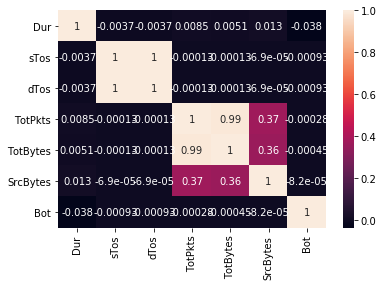

In [7]:
# There are relatively few of these in the dataset. So for now I will leave it like that and return to it later 
# Lets check correlation b/w the numerical fields
sns.heatmap(df_raw.corr(), annot=True)

In [8]:
# The correlation is not impressive. 
# we do notice that, as expected, TotBytes and TotPackets are correlated and therefore one should be removed.
# we will now try to see whether certain trends in the data can help us to classify it. 

#First we create 2 datasets of the normal and bot traffic
number_of_bots_rows = len(df_raw[df_raw['Bot'] == 1].index)
number_of_reg_rows = len(df_raw[df_raw['Bot'] == 0].index)

print(f"number of bot requests:{number_of_bots_rows} \nnumber of normal requests:{number_of_reg_rows}")

bots_data = df_raw[df_raw['Bot'] == 1] #data set that records bots traffic 
nrml_unbalanced = df_raw[df_raw['Bot'] == 0]#data set that records normal traffic 

number of bot requests:2691 
number of normal requests:370024


In [9]:
# Its quite obvious that the classes is VERY imbalanced. We will have to take care of this later on.
# Now lets try finding trends in the data, starting with the size of the request or the field SrcBytes
bot_stats = bots_data["SrcBytes"].describe()
nrml_stats = nrml_unbalanced["SrcBytes"].describe()
print(bot_stats)
print(nrml_stats)

count      2691.000000
mean       1574.726124
std       14155.776651
min          60.000000
25%         186.000000
50%         186.000000
75%         186.000000
max      241742.000000
Name: SrcBytes, dtype: float64
count    3.700240e+05
mean     1.727916e+03
std      1.592921e+05
min      0.000000e+00
25%      7.800000e+01
50%      8.200000e+01
75%      2.880000e+02
max      6.033451e+07
Name: SrcBytes, dtype: float64


In [10]:
# We see a lot of variability and outliers, so lets plot all the data under the 75% percentile.
# we choose a violine plot to see peaks in the data rather then just general stats. 
# "In a violin plot, On each side of the gray line is a kernel density estimation to show the distribution shape of the data.
# Wider sections of the violin plot represent a higher probability that members of the population will 
# take on the given value; 

from matplotlib.ticker import FormatStrFormatter
#We define a function that takes two datasets and plot them one next to the other
def compare_two_dist(bot_traffic, normal_traffic, title):
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10), sharey=False, sharex=False)
    sns.violinplot(data=bot_traffic,  inner="points", ax=ax1)
    sns.violinplot(data=normal_traffic,  inner="points", ax=ax2)
    ax1.set_ylim(bottom=np.amin(bot_traffic))
    ax2.set_ylim(bottom=np.amin(normal_traffic))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_title('Regular Traffic')
    ax1.set_title('Bot Traffic')
    f.suptitle(title, fontsize=16)
    plt.show()

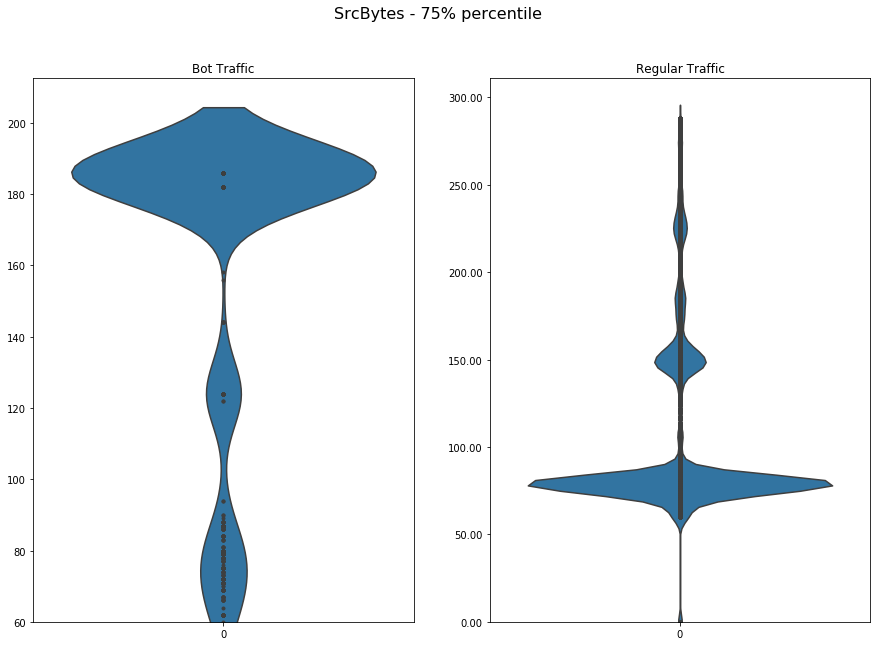

In [11]:
#bot_stats is the result of describe() and index 6 (bot_stats[6]) returns the 75s percentile
def get75Percentile(data, field):
    stats = data[field].describe()
    return data[field].loc[(data[field] < stats[6] + 1)].values.tolist()


bot_p75 = get75Percentile(bots_data, "SrcBytes")
nrml_p75 = get75Percentile(nrml_unbalanced, "SrcBytes")
compare_two_dist(bot_p75,nrml_p75, "SrcBytes - 75% percentile")



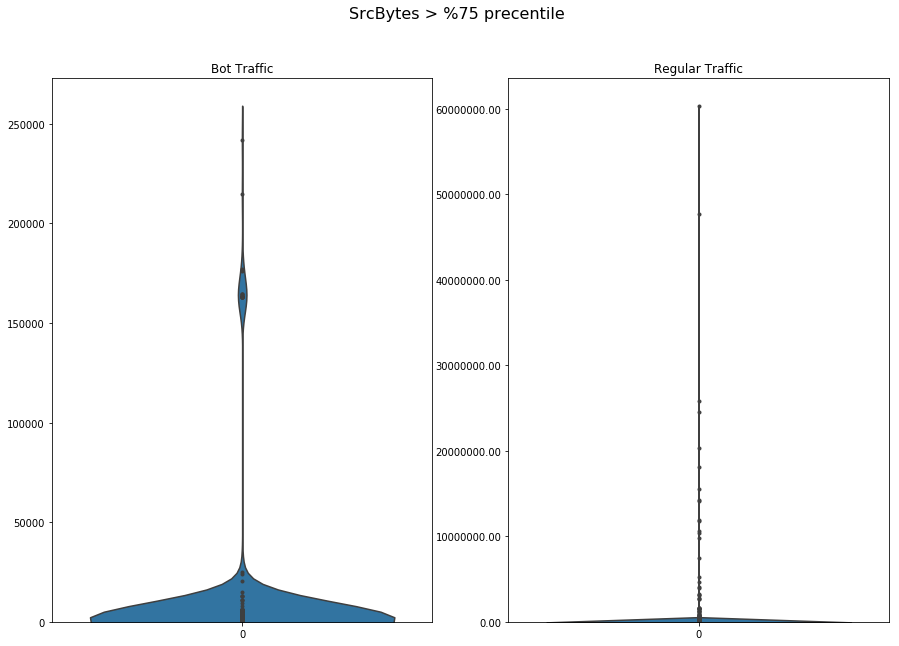

In [12]:
#So we clearly see that most of the bot traffic is distributed around 180 and 200 as the normal traffic between 50 and 100
# lets try to plot the "outliers" - the data above the 75 percentile.
bot_pTop = bots_data["SrcBytes"].loc[
    (bots_data["SrcBytes"] > bot_stats[6] + 1)].values.tolist()

nrml_pTop = nrml_unbalanced["SrcBytes"].loc[
    (nrml_unbalanced["SrcBytes"] > nrml_stats[6] + 1)].values.tolist()

compare_two_dist(bot_pTop,nrml_pTop, "SrcBytes > %75 precentile")


In [13]:
# We see that there is very little normal traffic in the 75-100 percetile, 
# whereas there is considerable bot traffic in the large bytes range
# this may be similar for the other weight maesurements. Lets check it for the Total Packets and total Bytes
bot_stats = bots_data["TotBytes"].describe()
nrml_stats = nrml_unbalanced["TotBytes"].describe()
print(bot_stats)
print(nrml_stats)

count      2691.000000
mean       4496.975474
std       30353.956696
min          62.000000
25%         186.000000
50%         186.000000
75%         398.000000
max      706733.000000
Name: TotBytes, dtype: float64
count    3.700240e+05
mean     1.561883e+04
std      2.106136e+06
min      6.000000e+01
25%      2.140000e+02
50%      2.700000e+02
75%      6.240000e+02
max      7.961421e+08
Name: TotBytes, dtype: float64


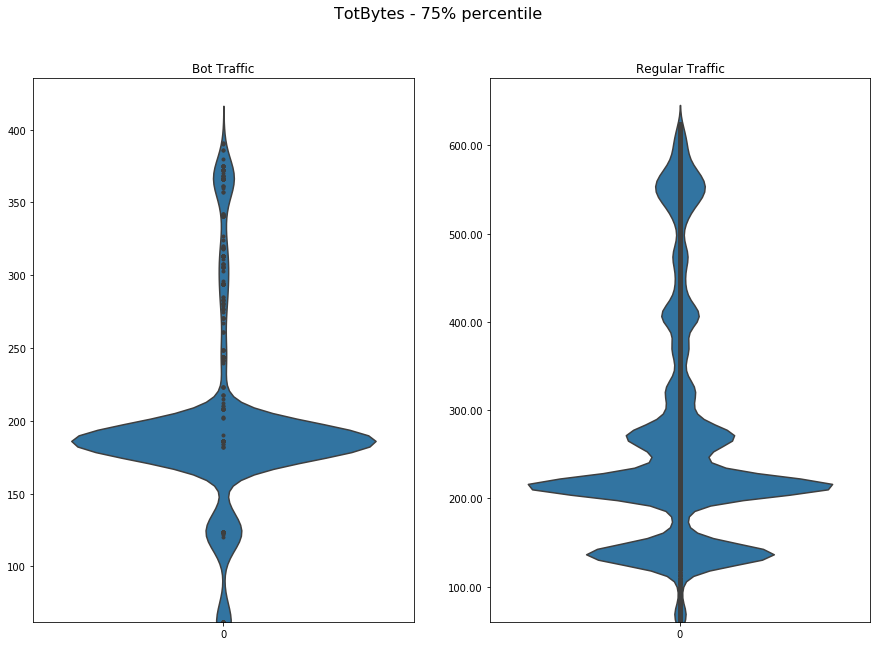

In [14]:
#now lets plot it
bot_p75 = get75Percentile(bots_data, "TotBytes")
nrml_p75 = get75Percentile(nrml_unbalanced, "TotBytes")
compare_two_dist(bot_p75,nrml_p75, "TotBytes - 75% percentile")

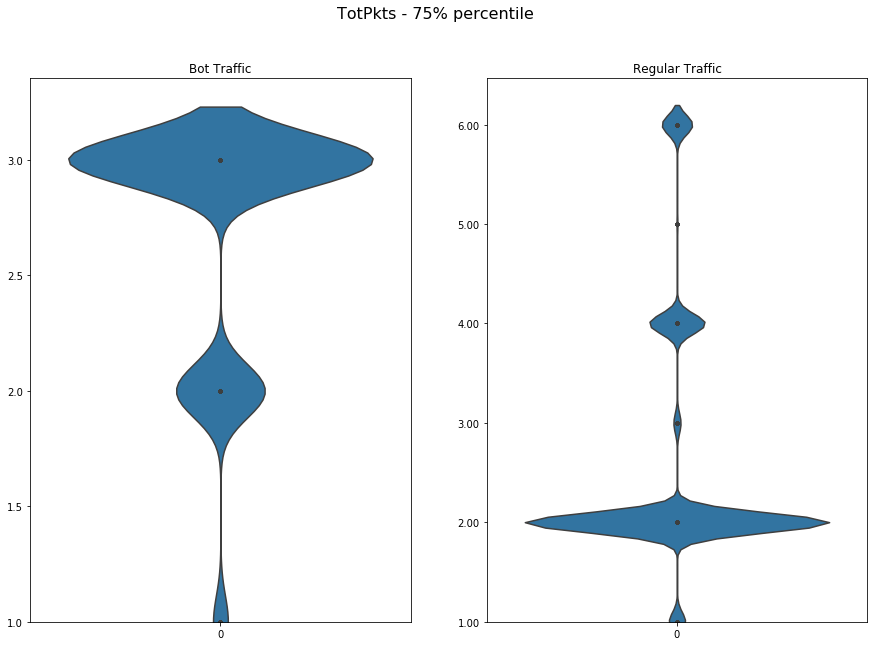

In [15]:
#and now for Total Packets
bot_p75 = get75Percentile(bots_data, "TotPkts")
nrml_p75 = get75Percentile(nrml_unbalanced, "TotPkts")
compare_two_dist(bot_p75,nrml_p75, "TotPkts - 75% percentile")

In [16]:
#So we see a trend that is relatively clear in the SrcBytes and in the TotalPacket fields 
#and less so in the totalBytes field

#Finally, lets check how these cols are correlated
bots_data.iloc[:,8:11].corr()


,TotPkts,TotBytes,SrcBytes
TotPkts,1.000000,0.562799,0.511086
TotBytes,0.562799,1.000000,0.617098
SrcBytes,0.511086,0.617098,1.000000


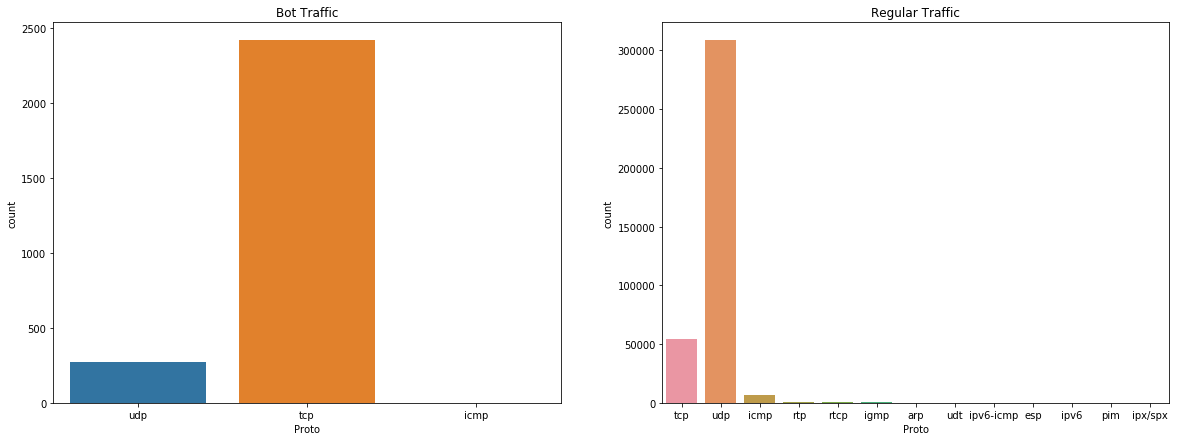

In [17]:
#now lets check the Protocol column  
b_freq_val = bots_data["Proto"].value_counts() #get a list of each protcol and its freq in the bot traffic
n_freq_val = nrml_unbalanced["Proto"].value_counts() #get a list of each protcol and its freq in the normal traffic

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,7), sharey=False, sharex=False)
sns.countplot(x="Proto", data=bots_data, ax=ax1)
sns.countplot(x="Proto", data=nrml_unbalanced, ax=ax2)
ax2.set_title('Regular Traffic')
ax1.set_title('Bot Traffic')
plt.show()

In [18]:
#Now lets check the State field 
state_freq = df_raw["State"].value_counts()
b_state_freq = bots_data["State"].value_counts() # get the freq table of the State in the Bot traffic
n_state_freq = nrml_unbalanced["State"].value_counts() # get the freq table of the State in the Normal traffic
_temp = pd.DataFrame(columns=['State','Bot', 'Nrml']) # create a dataframe that holds the freq for each type
for state in state_freq.index: 
    if(state in b_state_freq.index and state in n_state_freq.index):
        b_part  = b_state_freq[state]/bots_data["State"].size * 100 # get percentage of the data
        n_part = n_state_freq[state]/nrml_unbalanced["State"].size * 100 # get percentage of the data
        if(b_part > 3 or n_part > 3): #only take the meaningful ones that are more than %3
            _temp = _temp.append({'Bot':b_part, 'Nrml':n_part,'State':state}, ignore_index=True)
       
print(_temp)

       State        Bot       Nrml
0        CON  10.219249  80.072103
1  FSPA_FSPA  12.077295   8.068936
2         S_  65.626161   0.755897
3       S_RA   3.121516   0.547532
4   SRPA_SPA   3.604608   0.410784


In [19]:
# We see that most of the bot traffic (%65) has State = S_ comparing to less than 1% of the normal traffic, 
# while 80% of the normal traffic has CON state conmparing to %10 of the bot traffic

In [20]:
#let's move to the last feature: Duration
bots_data["Dur"].describe()

count    2691.000000
mean       29.794813
std       244.553050
min         0.000000
25%         2.514034
50%         8.992093
75%         9.013159
max      3599.312500
Name: Dur, dtype: float64

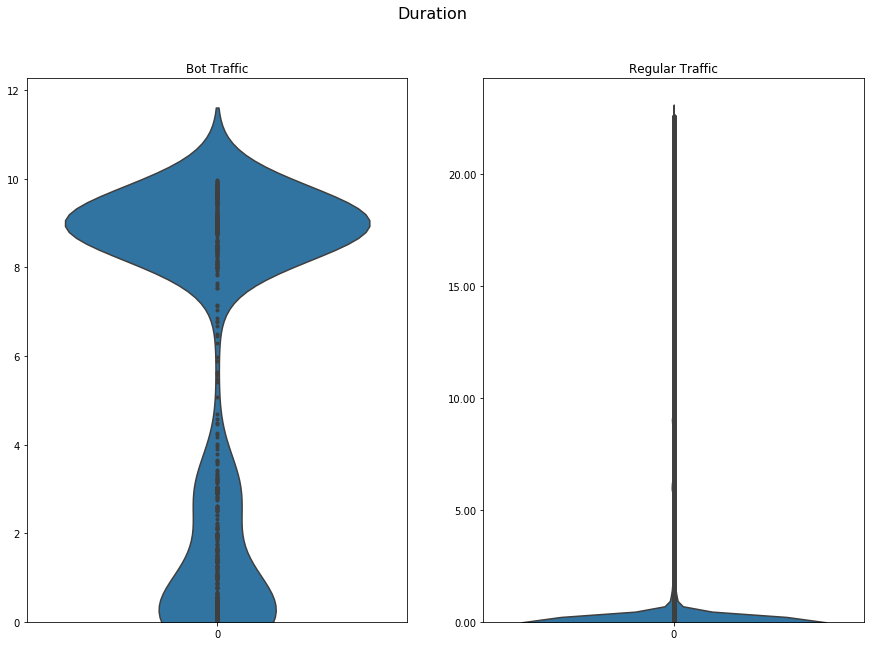

In [21]:
# We see that most data lies in the 75% and a lot of outliers lets plot the 75%
bot_p75 = get75Percentile(bots_data, "Dur")
nrml_p75 = get75Percentile(nrml_unbalanced, "Dur")

compare_two_dist(bot_p75, nrml_p75,"Duration")